In [2]:
import numpy as np 
import cv2
import math 
import matplotlib.pyplot as plt
import os 


# Apply filter and get the feature vector for an image
def imgFeatureVec(img):
    
    featurevec = []
    filterw = np.arange(2, img.shape[1], 2)
    filterh = np.arange(2, img.shape[0], 2)
    
    # Apply Haar filter
    for w in filterw:
        for x in range(img.shape[1] - w +1):
            for y in range(img.shape[0]):
                
                pval = np.sum(img[y, x+int(w/2):x+w]).astype(np.int32)
                nval = np.sum(img[y, x:x+int(w/2)]).astype(np.int32)
                
                featurevec.append(pval-nval)
                
    for h in filterh:
        for x in range(img.shape[1]):
            for y in range(img.shape[0] - h +1):
                
                pval = np.sum(img[y+int(h/2):y+h, x]).astype(np.int32)
                nval = np.sum(img[y:y+int(h/2), x]).astype(np.int32)
                
                featurevec.append(pval-nval)
        
    return featurevec

# read the image set and do vectorization
def getFeatureVectors(path): 

    features_train_p = []
    features_train_n = []
    features_test_p = []
    features_test_n = []
    
    for filename in os.listdir(path+'train/positive/'):
        
        img = cv2.imread(path+'train/positive/'+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        featurevec = imgFeatureVec(img)
        features_train_p.append(featurevec)
        
    for filename in os.listdir(path+'train/negative/'):
        
        img = cv2.imread(path+'train/negative/'+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        featurevec = imgFeatureVec(img)
        features_train_n.append(featurevec)    
        
    for filename in os.listdir(path+'test/positive/'):
        
        img = cv2.imread(path+'test/positive/'+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        featurevec = imgFeatureVec(img)
        features_test_p.append(featurevec)
        
    for filename in os.listdir(path+'test/negative/'):
        
        img = cv2.imread(path+'test/negative/'+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        featurevec = imgFeatureVec(img)
        features_test_n.append(featurevec)
    
    
    return np.array(features_train_p), np.array(features_train_n), np.array(features_test_p), np.array(features_test_n)





ImportError: DLL load failed while importing cv2: 找不到指定的模块。

In [16]:
imgpath = './'
# features_train_p, features_train_n, features_test_p, features_test_n = getFeatureVectors(imgpath)
# np.savetxt('features_train_p.txt', features_train_p, '%d')
# np.savetxt('features_train_n.txt', features_train_n, '%d')
# np.savetxt('features_test_p.txt', features_test_p, '%d')
# np.savetxt('features_test_n.txt', features_test_n, '%d')

features_train_p = np.loadtxt('features_train_p.txt', dtype = np.int16)
features_train_n = np.loadtxt('features_train_n.txt', dtype = np.int16)
features_test_p = np.loadtxt('features_test_p.txt', dtype = np.int16)
features_test_n = np.loadtxt('features_test_n.txt', dtype = np.int16)


In [44]:
#training
features_train = np.concatenate((features_train_p,features_train_n), axis=0)
labels_train = np.zeros(len(features_train))
labels_train[:len(features_train_p)] = 1

features_test = np.concatenate((features_test_p,features_test_n), axis=0)
labels_test = np.zeros(len(features_test))
labels_test[:len(features_test_p)] = 1

fn_test_list = []
fp_test_list = []

# go through cascades
for c in range(5):
    
    print(f'Cascade {c}')
    
    feat_num = features_train.shape[1]
    p_num = np.count_nonzero(labels_train)
    n_num = len(labels_train) - p_num
    
    # initialize weights
    weights = np.zeros(len(features_train))
    weights[:p_num] = 1/(p_num*2)
    weights[p_num:] = 1/(n_num*2)
    
    # find the weak classifier
    classifier = None
    min_error = float('inf')
    
    for i in range(feat_num):
        
        featvec = features_train[:, i]

        idx_sorted = np.argsort(featvec)
        
        features_sorted = featvec[idx_sorted]
        labels_sorted = labels_train[idx_sorted]
        weights_sorted = weights[idx_sorted]
        
        # calc error for every threshold
        pweights_sum = np.sum(weights[labels_train == 1])
        nweights_sum = np.sum(weights[labels_train == 0])
        
        pweights_sorted = weights_sorted.copy()
        pweights_sorted[np.where(labels_sorted == 0)[0]] = 0
        nweights_sorted = weights_sorted.copy()
        nweights_sorted[np.where(labels_sorted == 1)[0]] = 0
        
        pweights_sorted_cumsum = np.cumsum(pweights_sorted)
        nweights_sorted_cumsum = np.cumsum(nweights_sorted)
        
        errminus = pweights_sum - pweights_sorted_cumsum + nweights_sorted_cumsum
        errplus = nweights_sum - nweights_sorted_cumsum + pweights_sorted_cumsum
        err = np.concatenate((errplus, errminus))
        
        curr_min_err = np.min(err)
        
        # update the selected feature
        if curr_min_err<min_error:
            
            min_error = curr_min_err
            
            tempidx = err.argmin()
            featidx = tempidx % (p_num+n_num)
            polarity = tempidx // (p_num+n_num)
            threshold = features_sorted[featidx]
            
            if polarity == 0:
                idx_classified_positive = featvec >= threshold
                fn = 1 - np.count_nonzero(idx_classified_positive[:p_num])/p_num
                fp = np.count_nonzero(idx_classified_positive[p_num:])/n_num
                
            else:
                idx_classified_positive = featvec < threshold
                fn = 1 - np.count_nonzero(idx_classified_positive[:p_num])/p_num
                fp = np.count_nonzero(idx_classified_positive[p_num:])/n_num
                
        
            classifier = [featidx, polarity, threshold, (fn, fp), idx_classified_positive]
        
    # update dataset
    pfeatures_new = features_train[:p_num]
    nfeatures = features_train[p_num:]
    nfeatures_new = nfeatures[np.where(idx_classified_positive[p_num:] == 1)[0]]
    
    features_train = np.concatenate((pfeatures_new, nfeatures_new), axis=0)    
    labels_train = np.zeros(len(features_train))
    labels_train[:p_num] = 1
    
    #testing
    featvec_test = features_test[:, featidx]
    p_num_test = np.count_nonzero(labels_test)
    n_num_test = len(labels_test) - p_num_test
    
    if polarity == 0:
        test_classified_positive = featvec_test >= threshold
        fn_test = 1 - np.count_nonzero(test_classified_positive[:p_num_test])/p_num_test
        fp_test = np.count_nonzero(test_classified_positive[p_num_test:])/n_num_test

    else:
        test_classified_positive = featvec_test < threshold
        fn_test = 1 - np.count_nonzero(test_classified_positive[:p_num_test])/p_num_test
        fp_test = np.count_nonzero(test_classified_positive[p_num_test:])/n_num_test
    
      
    
    fn_test_list.append(fn_test)
    fp_test_list.append(fp_test)
    print(classifier)
    print(fn_test, fp_test)
    
    


Cascade 0
[920, 1, -106, (0.15774647887323945, 0.1831626848691695), array([False, False,  True, ..., False,  True,  True])]
0.9887640449438202 0.00909090909090909
Cascade 1
[507, 1, -5, (0.3633802816901408, 0.16459627329192547), array([ True, False, False, ..., False, False, False])]
0.8370786516853932 0.11818181818181818
Cascade 2
[342, 0, 99, (0.4126760563380282, 0.09433962264150944), array([False,  True, False,  True,  True,  True,  True, False, False,
        True, False, False,  True,  True,  True, False,  True,  True,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, F

[0, 0, -218, (0.0, 1.0), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  T

In [17]:
print(features_train_p.shape)
print(features_train_n.shape)
print(features_test_p.shape)
print(features_test_n.shape)
print(features_train_p[0,0])

(710, 11940)
(1758, 11940)
(178, 11940)
(440, 11940)
0


In [37]:
np.where(labels_sorted == 0)

(array([   0,    1,    2, ..., 2465, 2466, 2467], dtype=int64),)

In [42]:
features_train[p_num:][np.where(idx_classified_positive[p_num:] == 1)[0]]

array([[  12,    6,    0, ..., -181, -104,  -23],
       [   0,    0,   -1, ...,  265,  230,  195],
       [  -1,   -6,   -2, ..., -490, -549, -589],
       ...,
       [ -22,  -33,  -15, ...,  317,  451,  549],
       [  -6,   -6,    5, ..., -134, -136, -149],
       [  -1,    2,    6, ...,   51,   72,   75]], dtype=int16)

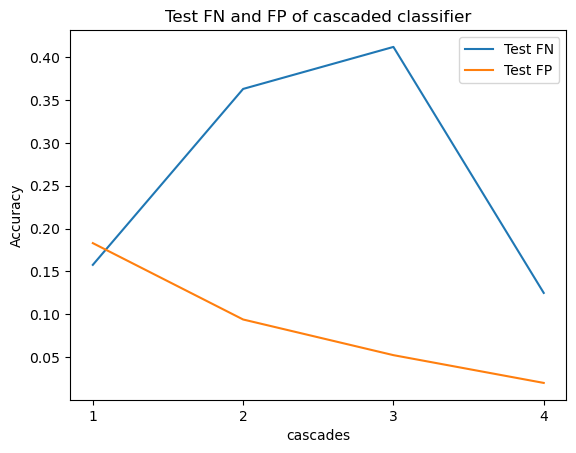

In [6]:
import matplotlib.pyplot as plt

fn_test_list = [0.15774, 0.363, 0.412, 0.125]
fp_test_list = [0.1831, 0.094, 0.0524, 0.02]
p = range(1, 5)

plt.figure()
plt.plot(p, fn_test_list, label= 'Test FN')
plt.plot(p, fp_test_list, label= 'Test FP')

plt.title('Test FN and FP of cascaded classifier')
plt.ylabel('Accuracy')
plt.xlabel('cascades')
plt.xticks(range(1, 5))
plt.legend()
plt.show()